In [1]:
import tomllib
from itertools import islice

import ehc_sn as ehc
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output, display

In [2]:
with open("configurations/navigation_network.toml", "rb") as f:
    data = tomllib.load(f)

In [3]:
parameters = ehc.Parameters.model_validate(data)
model = ehc.EHCNetwork(p=parameters)
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): EHCNetwork(
    (mapping): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(0.2000, device='cuda:0'), tau_mem_inv=tensor(0.5000, device='cuda:0'), v_leak=tensor(-40., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
    (inhibitory): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(0.1000, device='cuda:0'), tau_mem_inv=tensor(0.5000, device='cuda:0'), v_leak=tensor(-50., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
    (embedding): EILayer(
      (neurons): BaseLaye

In [4]:
current = 1.0  # Input current
xmin, xmax = 0, 40  # Neurons with added current

sensors_signal = torch.zeros(3000, 200).to(ehc.device)
sensors_signal[:2000, xmin:xmax] = current
embedding_signal = torch.zeros(3000, 200).to(ehc.device)
embedding_signal  ## Pass
signal_loader = zip(sensors_signal, embedding_signal)

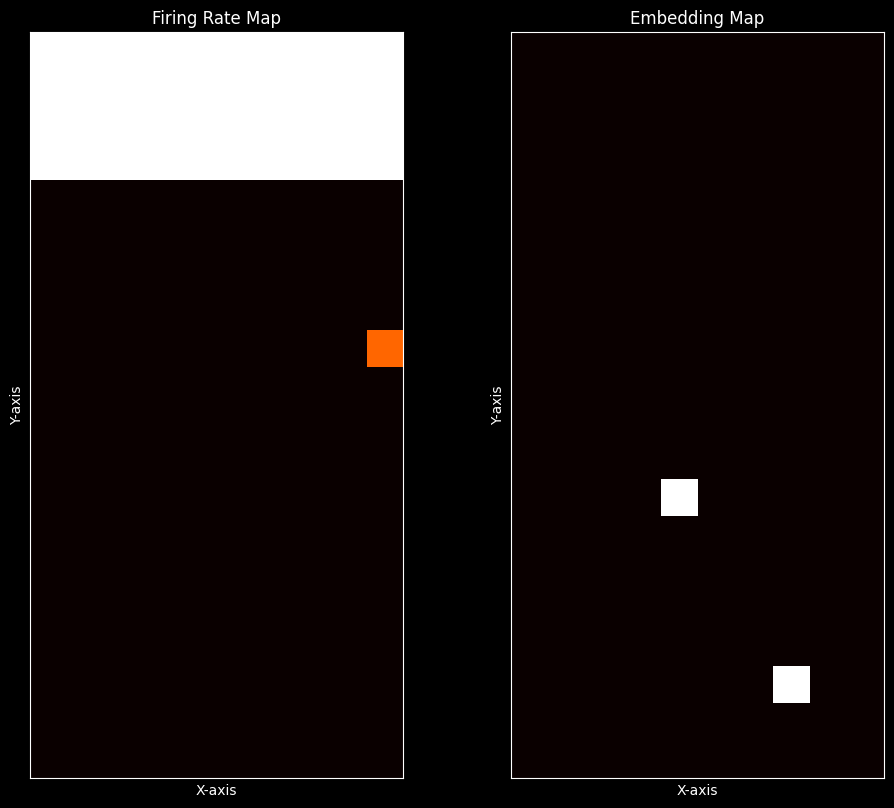

In [5]:
# Initializing the figure for the animation
zeros = torch.zeros(20, 10).cpu().numpy()  # Initial data for the image
vmin, vmax = 0, 0.01
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
imgfig = ax[0].imshow(zeros.copy(), cmap="hot", vmin=vmin, vmax=vmax)
imgemb = ax[1].imshow(zeros.copy(), cmap="hot", vmin=vmin, vmax=vmax)
fig.tight_layout()

# Set the titles and labels for the cognitive map figure
ax[0].set_title("Firing Rate Map")
ax[0].set_xlabel("X-axis"), ax[0].set_ylabel("Y-axis")
ax[0].set_xticks([]), ax[0].set_yticks([])

# Set the titles and labels for the embedding figure
ax[1].set_title("Embedding Map")
ax[1].set_xlabel("X-axis"), ax[1].set_ylabel("Y-axis")
ax[1].set_xticks([]), ax[1].set_yticks([])

# Set up the decoders to extract the firing rates
decoders = [ehc.decoders.HannDecoder(window_length=100) for _ in range(2)]

# Run simulation and update the figure
for sensors, memory in islice(signal_loader, 1000):

    # Get the next output from the model
    cmap, embedding = model(sensors, memory, stdp=False)

    # Update the image data
    cmap = decoders[0](cmap).reshape(20, 10)  # Reshape to match the image size
    imgfig.set_data(cmap.cpu().numpy())  # Update the image data

    # Update the embedding data
    embedding = decoders[1](embedding).reshape(20, 10)  # Reshape to match the image size
    imgemb.set_data(embedding.cpu().numpy())  # Update the embedding data

    # Clear the previous output and display the updated figure
    clear_output(wait=True)
    display(fig)  # Display the updated figure
    plt.pause(0.01)  # Pause to allow the figure to update

pass  # This is a placeholder to avoid display errors